特征工程


# 导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter


In [2]:
train = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')
print(train.shape, test.shape)

(150000, 31) (50000, 30)


In [3]:
pd.set_option('display.max_columns', None) #显示所有列
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
del train['SaleID']
train.columns

Index(['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

In [5]:
train.shape

(150000, 30)

In [6]:
def outliers_proc(data, col_name, scale=3):
    def box_plot_outliers(data_series, box_scale):
        #使用分位数确定保留数据的范围
        iqr = box_scale * (data_series.quantile(0.75) - data_series.quantile(0.25))
        val_low, val_up = data_series.quantile(0.25)-iqr, data_series.quantile(0.75)+iqr
        rule_low, rule_up = (data_series<val_low), (data_series>val_up)
        return (rule_low, rule_up), (val_low, val_up)
    
    data_copy = data.copy()
    data_series = data_copy[col_name]
    rule, value = box_plot_outliers(data_series, scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
#     print(index)
    print("Delete number is: {}".format(len(index)))
    data_copy = data_copy.drop(index)
    data_copy.reset_index(drop=True, inplace=True)
    print("clomn number is {}".format(data_copy.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the up bound is:")
    print(pd.Series(outliers).describe())
    
   
#     sns.boxplot(y=data[col_name])
    sns.boxplot(y=data_copy[col_name],  data=data_copy, palette="Set1")
    return data_copy
    

Delete number is: 963
clomn number is 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the up bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


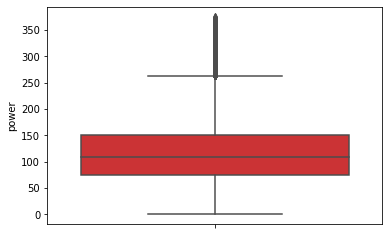

In [7]:
train = outliers_proc(train, 'power', scale=3)

In [8]:
train.shape

(149037, 30)

# 特征构造
pandas.to_datetime  参考资料：https://blog.csdn.net/DataCastle/article/details/84323603

In [9]:
train['train'] = 1
test['train'] = 0
data = pd.concat([train, test], ignore_index=True, sort=False)

In [10]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce'))-(pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce'))

In [11]:
data['used_time'].isnull().sum()

15072

In [12]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [13]:
data['city']

0         1
1         4
2         2
3          
4         6
         ..
199032    3
199033    1
199034    3
199035    1
199036    3
Name: city, Length: 199037, dtype: object

通过对DataFrame对象调用groupby()函数返回的结果是一个DataFrameGroupBy对象，而不是一个DataFrame或者Series对象，所以，它们中的一些方法或者函数是无法直接调用的，需要按照GroupBy对象中具有的函数和方法进行调用。

In [14]:
train_gb = train.groupby("brand")

In [15]:
train_gb.sum()

,name,regDate,model,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train
brand,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2145989186,629503458118,824638.0,48855.0,12570.0,4322.0,3110514,403973.0,82248724,0,0,633619051719,173719698,1.392331e+06,-5734.677738,7150.270484,5859.030047,-7228.000470,7779.415170,1353.980076,4374.951323,1790.496801,1702.501404,6369.239156,4088.968861,319.259924,-7132.215962,8112.887978,31429
1,858783982,273687235179,732083.0,21262.0,6843.0,4497.0,2106056,177027.5,36853672,0,0,275309462363,124044603,6.257410e+05,5311.482873,6445.232648,-5809.370746,-12803.036981,3529.860323,713.571318,2033.737066,876.261148,449.572895,-12716.056105,-5690.539618,15989.999711,-14492.216173,-673.788928,13656
2,24911955,6373626288,27010.0,1881.0,222.0,235.0,57990,3815.5,858676,0,0,6410985565,3766241,1.492114e+04,53.067633,-177.670172,-393.557865,-98.066555,86.877428,15.503812,19.331121,23.740648,17.322044,-466.066125,-635.236288,487.826737,-168.154845,-490.748056,318
3,172652105,49388764120,143552.0,4066.0,942.0,290.0,248316,28030.0,6539504,0,0,49614576724,15954226,1.111007e+05,535.118858,813.980696,-2371.544686,2536.807902,596.725348,119.925342,274.854692,181.808669,223.355047,-1444.907047,-809.997235,2647.779422,2266.137834,-3217.596468,2461
4,1073548452,332047902593,303985.0,26730.0,6942.0,5747.0,2712892,220666.5,41926485,0,0,334157498787,138279069,7.584395e+05,1015.173435,4261.536992,-4565.631356,-19002.545044,4344.274037,787.782497,2334.656766,1030.789589,456.787455,-10674.603690,-10638.516380,16050.876307,-21025.031052,-8.470919,16575
5,312012377,93414436087,120627.0,9081.0,1153.0,274.0,426398,57846.0,11921361,0,0,93987461206,15414322,2.020849e+05,80.193911,-1645.782367,1354.744887,2981.523636,1132.912546,207.781861,435.891218,252.020309,373.617048,1383.966634,1590.535796,-4153.776250,3893.560554,1929.651563,4662
6,690674327,204200726767,515776.0,17092.0,3134.0,773.0,961155,127112.5,26048254,0,0,205494256070,36457518,4.414455e+05,-157.937382,-1036.401507,7723.563350,4613.663989,2458.373696,455.673711,1221.437350,496.502569,764.393350,4623.236394,6604.407465,-10699.482596,5135.885591,5735.798097,10193
7,163546518,47262334127,158886.0,5029.0,531.0,128.0,257679,29671.0,6139775,0,0,47578374693,9905909,1.039897e+05,-47.535071,-959.226128,676.996861,1563.810259,584.255102,105.731520,212.447747,129.695816,196.021565,102.358355,-187.161795,-1435.092914,1343.206791,-1711.654278,2360
8,150266882,41471403733,166589.0,4240.0,513.0,237.0,198201,24482.0,5336966,0,0,41731885762,10017173,9.077391e+04,-775.706818,-402.097034,536.094117,2553.453203,496.191798,82.292449,208.430429,119.429556,205.083763,1030.185680,109.615947,-1137.097059,2352.779357,-1158.736006,2070


In [16]:
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')
data.head()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,SaleID,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850.0,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1,NaN,4385 days,1,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1,NaN,4757 days,4,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222.0,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1,NaN,4382 days,2,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1,NaN,7125 days,,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1,NaN,1531 days,6,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67


一般在建立分类模型时，需要对连续变量离散化，特征离散化后，模型会更稳定，降低了模型过拟合的风险。比如在建立申请评分卡模型时用logsitic作为基模型就需要对连续变量进行离散化，离散化通常采用分箱法。

分箱的重要性及其优势

离散特征的增加和减少都很容易，易于模型的快速迭代；
稀疏向量内积乘法运算速度快，计算结果方便存储，容易扩展；
离散化后的特征对异常数据有很强的鲁棒性：比如一个特征是年龄>30是1，否则0。如果特征没有离散化，一个异常数据“年龄300岁”会给模型造成很大的干扰；
特征离散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人。当然处于区间相邻处的样本会刚好相反，所以怎么划分区间是门学问；
特征离散化以后，起到了简化了逻辑回归模型的作用，降低了模型过拟合的风险。
可以将缺失作为独立的一类带入模型。

原文链接：https://blog.csdn.net/pylady/article/details/78882220

pd.cut(x,bins,right=True,labels=None,retbins=False,precision=3,include_lowest=False)
x：一维数组

bins：整数--将x划分为多少个等距的区间，序列--将x划分在指定序列中，若不在该序列中，则是Nan

right：是否包含右端点

labels：是否用标记来代替返回的bins

precision：精度

include_lowest：是否包含左端点

In [17]:
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [18]:
#删除原始数据
data = data.drop(['creatDate', 'regDate', 'regionCode','SaleID'], axis=1)

In [19]:
data.shape

(199037, 38)

In [20]:
data.columns

Index(['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'seller', 'offerType', 'price', 'v_0',
       'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10',
       'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time', 'city',
       'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [21]:
data.to_csv('data/data_for_tree.csv', index=0)

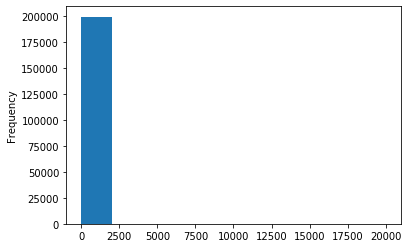

In [22]:
data['power'].plot.hist()

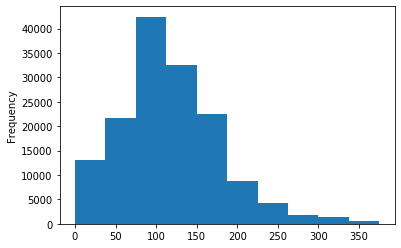

In [23]:
train['power'].plot.hist()

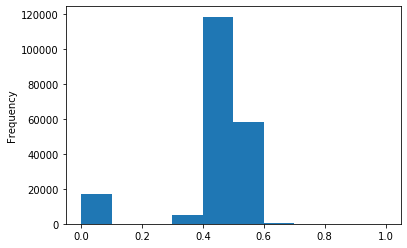

In [24]:
# 对power取 log，在做归一化
data['power'] = np.log(data['power'] + 1) 
data['power'] = (data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power']))
data['power'].plot.hist()

归一化方法有两种形式，一种是把数变为（0，1）之间的小数，一种是把有量纲表达式变为无量纲表达式，成为纯量。后者常见于微波之中，也就是电路分析、信号系统、电磁波传输等，研究物理的人会比较熟悉。而像我们这些普通的数据分析师的日常工作中，不太会遇见需要归一化为无量纲表达式的情况，因此只讨论归一化到 [0，1] 的情况。

归一化一般是把数据映射到 [ 0，1 ] ，但也有归一到  [ -1，1 ] 的情况，两种情况在Python中分别可以通过MinMaxScaler 或者 MaxAbsScaler方法来实现。
————————————————
minmaxscaler教程：https://blog.csdn.net/weixin_40683253/article/details/81508321

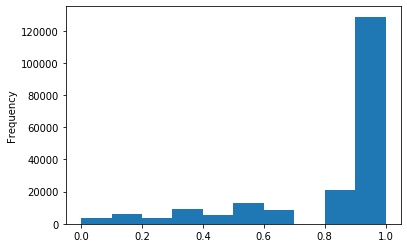

In [25]:
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) /
 (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

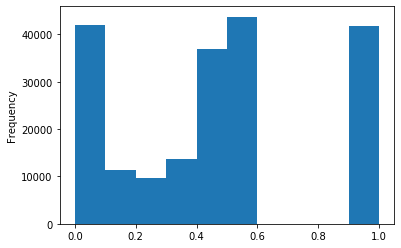

In [26]:
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
data['brand_amount']  = max_min(data['brand_amount'])
data['brand_amount'].plot.hist()

In [27]:
#类似方法处理别的必然的特征
b = ['brand_price_average', 'brand_price_max', 'brand_price_median', 'brand_price_min', 'brand_price_std', 'brand_price_sum']
for c in b:
    data[c] = max_min(data[c])

get_dummies 是利用pandas实现one hot encode的方式。详细参数请查看官方文档
 pandas.get_dummies(data, prefix=None, prefix_sep=’_’, dummy_na=False, columns=None, sparse=False, drop_first=False)[source]
参数说明：

data : array-like, Series, or DataFrame
 输入的数据
prefix : string, list of strings, or dict of strings, default None
 get_dummies转换后，列名的前缀
columns : list-like, default None
 指定需要实现类别转换的列名
dummy_na : bool, default False
 增加一列表示空缺值，如果False就忽略空缺值
drop_first : bool, default False
 获得k中的k-1个类别值，去除第一个
离散特征的编码分为两种情况：

1、离散特征的取值之间没有大小的意义，比如color：[red,blue],那么就使用one-hot编码

2、离散特征的取值有大小的意义，比如size:[X,XL,XXL],那么就使用数值的映射{X:1,XL:2,XXL:3}

例子：https://cloud.tencent.com/developer/article/1406408

In [28]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])
data.shape

(199037, 369)

In [29]:
data.columns

Index(['name', 'power', 'kilometer', 'seller', 'offerType', 'price', 'v_0',
       'v_1', 'v_2', 'v_3',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=369)

In [30]:
data.to_csv('data/data_for_lr.csv', index = 0)

特征选择的方法

1）Filter方法（过滤式）

（1）主要思想是：对每一维特征“打分”，即给每一维的特征赋予权重，这样的权重就代表着该特征的重要性，然后依据权重排序。

（2）先进行特征选择，然后去训练学习器，所以特征选择的过程与学习器无关。相当于先对特征进行过滤操作，然后用特征子集来训练分类器。

（3）主要方法

Chi-squared test（卡方检验）
Information gain（信息增益）
Correlation coefficient scores（相关系数）
2）Wrapper方法（包裹式）

（1）主要思想是：将子集的选择看作是一个搜索寻优问题，生成不同的组合，对组合进行评价，再与其他的组合进行比较。这样就将子集的选择看作是一个优化问题，这里有很多的优化算法可以解决，尤其是一些启发式的优化算法，如GA、PSO（如：优化算法-粒子群算法）、DE、ABC（如：优化算法-人工蜂群算法）等，

（2）直接把最后要使用的分类器作为特征选择的评价函数，对于特定的分类器选择最优的特征子集。

（3）主要方法有：递归特征消除算法

3）Embedded方法（嵌入式）

（1）主要思想是：在模型既定的情况下学习出对提高模型准确性最好的特征。也就是在确定模型的过程中，挑选出那些对模型的训练有重要意义的特征。

（2）简单易学的机器学习算法--岭回归（Ridge Regression），就是线性回归过程加入了L2正则项。

原文链接：https://blog.csdn.net/jliang3/article/details/88912464